In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pandas as pd

In [0]:
ratings = pd.read_csv('gdrive/My Drive/AIML/ratings_Electronics_Ver3.csv',encoding = "ISO-8859-1",usecols=[0,1,2])

In [46]:
ratings.head()

,userId,productId,ratings
0,A2CX7LUOHB2NDG,0321732944,5.0
1,A2NWSAGRHCP8N5,0439886341,1.0
2,A2WNBOD3WNDNKT,0439886341,3.0
3,A1GI0U4ZRJA8WN,0439886341,1.0
4,A1QGNMC6O1VW39,0511189877,5.0


In [6]:
ratings.head()

,ratings_Electronics.csv,0132793040,5.0
0,A2CX7LUOHB2NDG,0321732944,5.0
1,A2NWSAGRHCP8N5,0439886341,1.0
2,A2WNBOD3WNDNKT,0439886341,3.0
3,A1GI0U4ZRJA8WN,0439886341,1.0
4,A1QGNMC6O1VW39,0511189877,5.0


In [0]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Item based Collaborative Filtering & popularity based filtering

Load data

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from surprise import Dataset,Reader
from surprise import KNNWithMeans
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.model_selection import cross_validate
from collections import defaultdict
from surprise import SVD
# Import the libraries
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
!pip install scikit-surprise

     |████████████████████████████████| 6.5MB 9.2MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.0-cp36-cp36m-linux_x86_64.whl size=1678219 sha256=bfc0c533fe6197621214077e7c762e3212d5d4deb4bffdad49f036ce66111c27
  Stored in directory: /root/.cache/pip/wheels/cc/fa/8c/16c93fccce688ae1bde7d979ff102f7bee980d9cfeb8641bcf
Successfully built scikit-surprise


1. Read and explore the given dataset. ( Rename column/add headers, plot histograms, find data characteristics)

In [10]:
## the timestamp cols are of no interest for our current work,so only reading the first 3 columns
ratings = pd.read_csv('gdrive/My Drive/AIML/ratings_Electronics_Ver3.csv',encoding = "ISO-8859-1",usecols=[0,1,2])
ratings.columns = ['userId','productId','ratings']
ratings.head()

,userId,productId,ratings
0,A2CX7LUOHB2NDG,0321732944,5.0
1,A2NWSAGRHCP8N5,0439886341,1.0
2,A2WNBOD3WNDNKT,0439886341,3.0
3,A1GI0U4ZRJA8WN,0439886341,1.0
4,A1QGNMC6O1VW39,0511189877,5.0


In [11]:
ratings.shape

(7824482, 3)

In [12]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
userId       object
productId    object
ratings      float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [0]:
ratings.userId=ratings.userId.astype(str)                          #For safer side converting the attributes userId and Product Id into string
ratings.productId=ratings.productId.astype(str)
#ratings.ratings=ratings.ratings.astype(int)

In [14]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
userId       object
productId    object
ratings      float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [15]:
ratings.describe().T

,count,mean,std,min,25%,50%,75%,max
ratings,7824481.0,4.012337,1.38091,1.0,3.0,5.0,5.0,5.0


Data Exploration and Transformation


In [16]:
ratings.isna().sum()

userId       0
productId    0
ratings      1
dtype: int64

In [17]:
ratings.isnull().any()

userId       False
productId    False
ratings       True
dtype: bool

In [0]:
ratings_1 = ratings.dropna()    

In [19]:
ratings.shape

(7824482, 3)

In [20]:
ratings_1.shape #null values Dropped

(7824481, 3)

In [21]:
print("Total Unique userid :", len(ratings_1["userId"].unique()))

Total Unique userid : 4201696


Q: Who are the users with maximum no of products purchased?

In [22]:
ratingscount = ratings_1["userId"].value_counts() #From this we can find the users who have maximum number of purchase in the amazon site
ratingscount

A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
                 ... 
AJQPPXG6YHPTV       1
A3QYYMJLL7SKQK      1
A11VOZW49MXNZC      1
A3C8BW8P0RL6Z3      1
A35H600VAZ967Q      1
Name: userId, Length: 4201696, dtype: int64

#As per the criteria considering the users who have done purchase for more than 50 products

In [23]:
greaterthanfiftyusers = ratingscount[ratingscount >=50].index
greaterthanfiftyusers

Index(['A5JLAU2ARJ0BO', 'ADLVFFE4VBT8', 'A3OXHLG6DIBRW8', 'A6FIAB28IS79',
       'A680RUE1FDO8B', 'A1ODOGXEYECQQ8', 'A36K2N527TXXJN', 'A2AY4YUOX2N1BQ',
       'AWPODHOB4GFWL', 'A25C2M3QF9G7OQ',
       ...
       'A319Y83RT0MRVR', 'A2NYOY6H42SORF', 'A3LSEIG2PIJYBL', 'A7Z2J9V37ABCO',
       'A3JAH5WW61N2EK', 'A19N3S7CBSU6O7', 'A21S26XYPGXJZX', 'A1EOTB1WHLSW6G',
       'A3VZH0PWLQ9BB1', 'AXU8RH1DEV21H'],
      dtype='object', length=1540)

In [24]:
len(greaterthanfiftyusers.unique())

1540

In [25]:
##to find highest purchased product
ratings_1.productId.value_counts()

B0074BW614    18244
B00DR0PDNE    16454
B007WTAJTO    14172
B0019EHU8G    12285
B006GWO5WK    12226
              ...  
B00EV3O2BK        1
B0093TE5LO        1
B000OY68JY        1
B00326NS4Y        1
B002RL8UDO        1
Name: productId, Length: 476001, dtype: int64

Maximum number of products purchased

In [26]:
ratings_1.shape

(7824481, 3)

Distribution with respect to Ratings and user

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f03c61ac160>]],
      dtype=object)

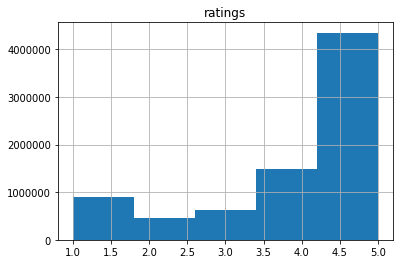

In [27]:
ratings_1.hist('ratings',bins = 5)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f03c62012e8>]],
      dtype=object)

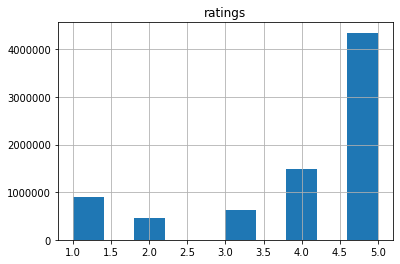

In [28]:
ratings_1.hist('ratings',bins = 10)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f03a7842358>]],
      dtype=object)

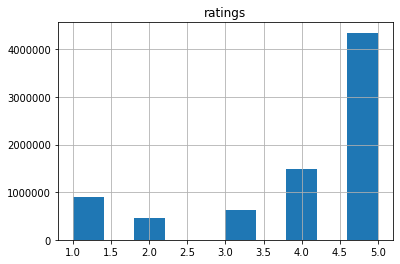

In [29]:
ratings_1.hist('ratings')

From the histogram we conclude that we have many products with rating 5, secondly we have second highest products with rating 4, few products we have 3 and we have very few products on rating 2 and we have more number of products with 1 rating when compared with rating 2 products, which are very low

Ratings Distribution with respect to Product

In [30]:
ratings_1.groupby('productId').count()
 #the product correspoding count is displayed, e.g product id 0321732944 has 1 userid count, hence rating count is 1, 
 #i.e. product column is grouped by and the count with respect to other attributes are displayed 

,userId,ratings
productId,,
0321732944,1,1
0439886341,3,3
0511189877,6,6
0528881469,27,27
0558835155,1,1
...,...,...
BT008G3W52,1,1
BT008SXQ4C,1,1
BT008T2BGK,1,1


In [31]:
ratings_1.groupby('productId')['ratings'].count() #product ratings and count is showing ascending order

productId
0321732944     1
0439886341     3
0511189877     6
0528881469    27
0558835155     1
              ..
BT008G3W52     1
BT008SXQ4C     1
BT008T2BGK     1
BT008UKTMW    15
BT008V9J9U     1
Name: ratings, Length: 476001, dtype: int64

In [32]:
ratings_1.groupby('productId')['ratings'].count().reset_index().sort_values('ratings', ascending=False)[:10] 
#resetting the index as we are doing a group by operation and displaying the first top products

,productId,ratings
308397,B0074BW614,18244
429571,B00DR0PDNE,16454
327307,B007WTAJTO,14172
102803,B0019EHU8G,12285
296624,B006GWO5WK,12226
178600,B003ELYQGG,11617
178812,B003ES5ZUU,10276
323012,B007R5YDYA,9907
289774,B00622AG6S,9823
30275,B0002L5R78,9487


product id B0074BW614 has highest number of ratings

In [33]:
ratings_1.head()

,userId,productId,ratings
0,A2CX7LUOHB2NDG,0321732944,5.0
1,A2NWSAGRHCP8N5,0439886341,1.0
2,A2WNBOD3WNDNKT,0439886341,3.0
3,A1GI0U4ZRJA8WN,0439886341,1.0
4,A1QGNMC6O1VW39,0511189877,5.0


Ratings Distribution with respect to user_id

In [34]:
ratings_1.groupby('userId')['ratings'].count().reset_index().sort_values('ratings', ascending=False)[:10]

,userId,ratings
3263531,A5JLAU2ARJ0BO,520
3512451,ADLVFFE4VBT8,501
2989526,A3OXHLG6DIBRW8,498
3291008,A6FIAB28IS79,431
3284634,A680RUE1FDO8B,406
755206,A1ODOGXEYECQQ8,380
2424036,A36K2N527TXXJN,314
1451394,A2AY4YUOX2N1BQ,311
4100926,AWPODHOB4GFWL,308
3935038,ARBKYIVNYWK3C,296


Most of the users in the data gave 0-1 ratings, the most productive user have given 520 ratings.

2.Take a subset of the dataset to make it less sparse/ denser. ( For example, keep the users only who has given 50 or more number of ratings )

To reduce the dimensionality of the data set, and avoid running into “memory error”, we are considering the products that are frequently purchased and frequently purchasing user and filter out rarely rated products and rarely rating user

In [37]:
min_product_ratings = 50
filter_products = ratings_1['productId'].value_counts() >= min_product_ratings  #considering the products which are bought more than 50 times
filter_products = filter_products[filter_products].index.tolist()

min_user_ratings = 50
filter_users = ratings_1['userId'].value_counts() >= min_user_ratings           #considering the users who have done more that 50 purchases
filter_users = filter_users[filter_users].index.tolist()

df_new = ratings_1[(ratings_1['productId'].isin(filter_products)) & (ratings_1['userId'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(ratings_1.shape))
print('The new data frame shape:\t{}'.format(df_new.shape))

The original data frame shape:	(7824481, 3)
The new data frame shape:	(79182, 3)


Transforming data to surprise format

In [47]:
df_new.head()

,userId,productId,ratings
491,A3CLWR1UUZT6TG,0972683275,5.0
630,A3TAS1AG6FMBQW,0972683275,5.0
1002,A2Y4H3PXB07WQI,0972683275,4.0
1137,A25RTRAPQAJBDJ,0972683275,5.0
1309,A3LDPF5FMB782Z,1400501466,5.0


In [48]:
df_new["ratings"].unique()

array([5., 4., 1., 3., 2.])

In [0]:
reader = Reader(rating_scale=(1, 5))

In [0]:
##loading data using surprise package
data = Dataset.load_from_df(df_new[['userId','productId', 'ratings']], reader)

In [51]:
data

3. Split the data randomly into train and test dataset. ( For example, split it in 70/30 ratio)

In [0]:
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=.30,random_state=0)  #splitting the data 70/30

In [53]:
type(trainset)

surprise.trainset.Trainset

So far we have picked the users who purchased more than 50 time and products that are purchased more than 50 times

Now are doing a popularity based model - where in a situation where one user can rate a product 5 and other user can rate the same product as 4 and other user can rate the same product as 3, In order to find out products that is highly rated we have to take the mean of the ratings for the corresponding products


In [56]:
df_new.groupby('productId')['ratings'].count()

productId
0972683275     4
1400501466     6
1400501520     1
1400501776     2
1400532620     2
              ..
B00K91DB7Y    26
B00KFAGCUM     7
B00KINSDK8     1
B00KWHMR6G     2
B00L3YHF6O    14
Name: ratings, Length: 16993, dtype: int64

In [57]:
df_new.groupby('productId').count()

,userId,ratings
productId,,
0972683275,4,4
1400501466,6,6
1400501520,1,1
1400501776,2,2
1400532620,2,2
...,...,...
B00K91DB7Y,26,26
B00KFAGCUM,7,7
B00KINSDK8,1,1


In [59]:
df_new[df_new.productId == '0972683275'] 

#here you can see the product 0972683275 was bought by 4 user but 3 users have given 5 rating and 1 user is given 4, hence the mean rating is 4.75
#Note :- But as per product these is bought only 4 times, but as per users we have many records

,userId,productId,ratings
491,A3CLWR1UUZT6TG,0972683275,5.0
630,A3TAS1AG6FMBQW,0972683275,5.0
1002,A2Y4H3PXB07WQI,0972683275,4.0
1137,A25RTRAPQAJBDJ,0972683275,5.0


In [54]:
df_new.groupby('productId')['ratings'].mean().head()

productId
0972683275    4.750000
1400501466    3.333333
1400501520    5.000000
1400501776    4.500000
1400532620    3.000000
Name: ratings, dtype: float64

In [61]:
#sorting the ratings in reverse order
df_new.groupby('productId')['ratings'].mean().sort_values(ascending=False).head()

productId
B00L3YHF6O    5.0
B002JCSV5I    5.0
B002J47Q3O    5.0
B002IY598O    5.0
B002IXZ5DE    5.0
Name: ratings, dtype: float64

Now there is mislead here, we are getting ratings as 5 for the product B00L3YHF60, the question is how many users have given the rating as 5 here, say for example - like in previous case if the product is bought less( 3 or 4) in numbers and the users who bought this product along with the other products are more then they may come into picture here.

If 4 users have bought the product and have given 5 rating then this is a good product

But our case is we need to find more number of products bought by more number of users and have given good rating 

In [62]:
df_new.groupby('productId')['ratings'].count().sort_values(ascending=False).head()

productId
B0088CJT4U    206
B003ES5ZUU    184
B000N99BBC    167
B007WTAJTO    164
B00829TIEK    149
Name: ratings, dtype: int64

Here we can see that product B0088CJT4U is bought by more users and have given the rating, On continuation with the previous point we need to enhance the mean of the rating for the product and display in the reverse order

In [0]:
ratings_mean_count = pd.DataFrame(df_new.groupby('productId')['ratings'].mean()) # Here the rating mean as calculated and accomodated in a dataset

In [64]:
ratings_mean_count.head()

,ratings
productId,
0972683275,4.750000
1400501466,3.333333
1400501520,5.000000
1400501776,4.500000
1400532620,3.000000


In [0]:
ratings_mean_count['rating count'] = pd.DataFrame(df_new.groupby('productId')['ratings'].count()) 

In [66]:
ratings_mean_count.head()

,ratings,rating count
productId,,
0972683275,4.750000,4
1400501466,3.333333,6
1400501520,5.000000,1
1400501776,4.500000,2
1400532620,3.000000,2


Top 5 recommendations using popularity based model

In [77]:
ratings_mean_count.sort_values(['rating count'], ascending=[False]).head() 
#here we are considering the entire dataset 'ratings_mean_count' in that we are considering and manipulating 'rating count' values to 
#display in descending order

,ratings,rating count
productId,,
B0088CJT4U,4.218447,206
B003ES5ZUU,4.864130,184
B000N99BBC,4.772455,167
B007WTAJTO,4.701220,164
B00829TIEK,4.436242,149


The above gives the top 5 list of products that has good number of ratings as well as popular bought by the users

Based on the spilt of training set and test set, we can get the count of number of users against the their ratings

In [78]:
# user item rating data can be obtained as follows
user_records = trainset.ur
type(user_records)

collections.defaultdict

In [85]:
user_records[0]

[(0, 5.0),
 (813, 4.0),
 (5409, 4.0),
 (1277, 4.0),
 (64, 5.0),
 (747, 5.0),
 (534, 5.0),
 (4093, 2.0),
 (4546, 5.0),
 (1198, 5.0),
 (1794, 5.0),
 (8182, 5.0),
 (326, 2.0),
 (5632, 4.0),
 (1363, 3.0),
 (2247, 5.0),
 (181, 4.0),
 (3134, 3.0),
 (1923, 4.0),
 (1151, 4.0),
 (4931, 3.0),
 (1028, 4.0),
 (1027, 4.0),
 (10252, 5.0),
 (11097, 5.0),
 (360, 5.0),
 (934, 5.0),
 (2706, 5.0),
 (547, 5.0),
 (3186, 5.0),
 (291, 4.0),
 (843, 5.0),
 (8968, 4.0)]

In [86]:
# However the ids are the inner ids and not the raw ids
# raw ids can be obatined as follows

print(trainset.to_raw_uid(0))
print(trainset.to_raw_iid(344))

AWH2AY17ZU7W2
B003ES5ZR8


In [98]:
print(trainset.to_raw_uid(0)) # u id values - raw uid values gives the inner uid value

AWH2AY17ZU7W2


In [99]:
trainset.to_inner_uid("AWH2AY17ZU7W2") #u id values - inner uid values gives the raw uid values

0

In [100]:
print(trainset.to_raw_iid(344))

B003ES5ZR8


In [102]:
trainset.to_inner_iid("B003ES5ZR8") 

344

Build Collaborative Filtering model

ITEM-ITEM COLLABORATIVE FILTERING

Since our goal is to recommend new products to each user based on his/her habits we go for item based one. e.g This can bring out a brand based products i.e. particular company`s product, if the user purchases many samsung mobiles, the new samsung mobiles only will be recommened to the user

user based collaborativefiltering will be used when we want to predict the user rating for a particular product. E.g This is generic method where if a users gives 5 rating for all types of toys and 2 rating for all types of soap, Then all types of toys with 5 ratings(by other users) will be displayed

We are implementing the model using KNNwithmeans algorithm for the current work

In [87]:
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

# run the trained model against the testset
test_pred = algo.test(testset)

# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

# if you wanted to evaluate on the trainset
print("Item-based Model : Training Set")
train_pred = algo.test(trainset.build_testset())
accuracy.rmse(train_pred)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


Item-based Model : Test Set
RMSE: 1.1360


1.1359978091309944

Item-based Model : Training Set
RMSE: 0.0187


0.018661735297796852

6.Evaluate both the models. ( Once the model is trained on the training data, it can be used to compute the error (like RMSE) on predictions made on the test data.) You can also use a different method to evaluate the models.

Evaluating Model Performance:we evaluate only collaborative filtering model as we did only a group by recommendation for popularity based

As seen above the rmse of train data is 0.019 whereas in test it is 1.13,which implies the model has not performed very well

In [0]:
SVD Model

In [89]:
svd_model = SVD(n_factors=50,reg_all=0.01)
svd_model.fit(trainset)


In [90]:
accuracy.rmse(test_pred)

RMSE: 1.1360


1.1359978091309944

Using SVD also we got rmse as 1.13,now lets try Parameter tuning of SVD Recommendation system

In [0]:
from surprise.model_selection import GridSearchCV
param_grid = {'n_factors' : [5,10,15], "reg_all":[0.01,0.02]}
svd_tuned = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3,refit = True)

In [0]:
svd_tuned.fit(data)

In [93]:
svd_tuned.param_combinations

[{'n_factors': 5, 'reg_all': 0.01},
 {'n_factors': 5, 'reg_all': 0.02},
 {'n_factors': 10, 'reg_all': 0.01},
 {'n_factors': 10, 'reg_all': 0.02},
 {'n_factors': 15, 'reg_all': 0.01},
 {'n_factors': 15, 'reg_all': 0.02}]

In [94]:
svd_tuned.best_params

{'rmse': {'n_factors': 5, 'reg_all': 0.02}}

In [0]:
test_predict_svd_tuned= svd_tuned.test(testset)

In [96]:
test_predict_svd_tuned[0:5]

[Prediction(uid='A28UMA3GW9L124', iid='B001GX6MJ8', r_ui=3.0, est=3.480739182853493, details={'was_impossible': False}),
 Prediction(uid='A38NHXL5257E3B', iid='B001D60LG8', r_ui=5.0, est=4.4370048200068215, details={'was_impossible': False}),
 Prediction(uid='A36IHC0K68NS2', iid='B005DKZTNK', r_ui=3.0, est=3.667188362856892, details={'was_impossible': False}),
 Prediction(uid='A231WM2Z2JL0U3', iid='B00005ARK3', r_ui=4.0, est=4.119383098879968, details={'was_impossible': False}),
 Prediction(uid='A2AC6GQ24S45GA', iid='B001S2RCWI', r_ui=5.0, est=4.617365248189364, details={'was_impossible': False})]

In [97]:
accuracy.rmse(test_predict_svd_tuned)

RMSE: 0.8579


0.8579425466242709

As seen above the rmse is reduced fairly in SVD after parameter tuning,so we shall use this to generate recommendations to users

7. Get top - K ( K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products.

In [0]:
def get_top_n(predictions, n):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [104]:
top_n = get_top_n(test_predict_svd_tuned,5)
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

A28UMA3GW9L124 ['B0002D6QJO', 'B008JJLW4M', 'B000N99BBC', 'B000VX6XL6', 'B002IO2UM2']
A38NHXL5257E3B ['B003SGCO3E', 'B00BOHNYU6', 'B004J3ZV62', 'B004Q3R9AQ', 'B00CB2F65O']
A36IHC0K68NS2 ['B004ING996', 'B00ATM1MGA', 'B00HMREOLK', 'B001FAACHK', 'B009N8M2P6']
A231WM2Z2JL0U3 ['B00008OE6I', 'B00006HZ0L', 'B00005LB8P', 'B00008OE5G', 'B0000658CG']
A2AC6GQ24S45GA ['B001TOD7ME', 'B009VV56TY', 'B009E6J1BU', 'B001S2RCWI', 'B000PGHCG4']
A3OXHLG6DIBRW8 ['B001T9NUJE', 'B00BCA41PW', 'B00461E7JE', 'B002VPE1X4', 'B001ID829O']
A2XA8CW5DF4MNZ ['B000TKHBDK', 'B001TOD7ME', 'B00387EW1K', 'B000P6R6CY', 'B000AP05BO']
AG35JCCQWDRCS ['B000068O16', 'B0036Q7MV0', 'B001MSVPM6', 'B00AXTQQDS', 'B0045TYDNC']
A2X3L31KCXBHCL ['B00829THEG', 'B0044DEDC0', 'B00DQZQ5T6', 'B000B63KSM', 'B005EM6IAA']
A33YZNZIRA3H97 ['B00006I5J7', 'B00BOHNYTW', 'B00AXTQQDS', 'B00HFRWWAM', 'B00BFO14W8']
AX05DBU8IRUWY ['B006W8U2MU', 'B007WTAJTO', 'B001FO4QHI', 'B00FISD9DO', 'B00IKCQ0EK']
A296QED1MV1V0J ['B0058G40O8', 'B001S2PPT0', 'B008AST7R6',

Summarizing the insights:-

we considered three columns userId, productId, and ratings .

We analyzed the dataset and plotted the ratings,user based ratings and other needed info

To avoid memory issues we considered a subset of data(users who have given atleast 50 ratings/products rated atleast 50 times).


We implemented popularity based recommendations by listing out the higly rated products with the highest number of ratings.Always note that popularity based recommendation is same regardless of the user.

We implemented item based collaborative filtering model,as our area of interest is to provide product recommendations for the user.


For the current work we used KNNwithmeans model and we got a train rmse of 0.019 and test rmse of 1.13 which clearly indicates that the model is not generalized,so we tried implementing SVD and the rmse was 0.85.


We formulated top 5 recommendations for each user using SVD parameter tuned model